In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the arrays saved from processing.ipynb file
X_train = np.load('X_train_scaled.npy')
X_val = np.load('X_val_scaled.npy')

y_train = pd.read_csv('y_train.csv')['price']
y_val = pd.read_csv('y_val.csv')['price']

print("Data loaded successfully!")

Data loaded successfully!


XGBoost (Log-Scale)
Insight: Training on the log-transformed target minimizes the impact of price variance and helps the model learn relative percentage errors rather than absolute dollar differences

In [2]:
# values in "Log-Scale"
baseline_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    early_stopping_rounds=50  
)
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100 
)
preds = baseline_model.predict(X_val)
real_mae = mean_absolute_error(y_val, preds)

print(f"Baseline RMSE: {np.sqrt(mean_squared_error(y_val, preds))}")
print(f"True MAE (Actual Price): ${real_mae:,.2f}")
print(f"Baseline R2: {r2_score(y_val, preds)}")

[0]	validation_0-rmse:0.50259
[100]	validation_0-rmse:0.16822
[200]	validation_0-rmse:0.16309
[300]	validation_0-rmse:0.16162
[400]	validation_0-rmse:0.16117
[488]	validation_0-rmse:0.16120
Baseline RMSE: 0.16110022499196344
True MAE (Actual Price): $0.11
Baseline R2: 0.905285157772918


 XGBoost (Original Scale)
 Insight: Evaluating on the original scale provides the "financial reality" of the model, showing a baseline $R^2$ of 0.9106 and revealing that high-value outliers are the primary source of error.

In [3]:
# values in "Original Scale"
y_val_original = np.expm1(y_val)
preds_original = np.expm1(preds)

real_rmse = np.sqrt(mean_squared_error(y_val_original, preds_original))
real_mae = mean_absolute_error(y_val_original, preds_original)
real_r2 = r2_score(y_val_original, preds_original)

print(f"True RMSE (Actual Price): {real_rmse:.2f}")
print(f"True MAE (Actual Price): ${real_mae:,.2f}")
print(f"True R2 Score: {real_r2:.4f}")

True RMSE (Actual Price): 102712.07
True MAE (Actual Price): $60,400.48
True R2 Score: 0.9106


Optimized LightGBM
Insight: Switching to an optimized LightGBM increased the $R^2$ to 0.9133 by better handling large tabular datasets and utilizing more complex leaf-wise growth patterns.

In [4]:
import lightgbm as lgb

# Load and force into pure NumPy arrays
X_train_clean = np.ascontiguousarray(np.load('X_train_scaled.npy'))
X_val_clean = np.ascontiguousarray(np.load('X_val_scaled.npy'))

#  convert target to flat arrays
y_train_clean = y_train.values
y_val_clean = y_val.values

# Convert NumPy to DataFrame 
feature_names = [f"f_{i}" for i in range(X_train_clean.shape[1])]
X_train_df = pd.DataFrame(X_train_clean, columns=feature_names)
X_val_df = pd.DataFrame(X_val_clean, columns=feature_names)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 3000,
    'learning_rate': 0.02,        
    'num_leaves': 63,             
    'max_depth': 12,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,      
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.5,             
    'lambda_l2': 0.5,
    'random_state': 42,
    'verbosity': -1
}

model = lgb.LGBMRegressor(**params)
model.fit(
    X_train_df, y_train_clean,
    eval_set=[(X_val_df, y_val_clean)],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
)

preds_log = model.predict(X_val_df)
y_val_orig = np.expm1(y_val_clean)
preds_orig = np.expm1(preds_log)

rmse = np.sqrt(mean_squared_error(y_val_orig, preds_orig))
mae = mean_absolute_error(y_val_orig, preds_orig)
r2 = r2_score(y_val_orig, preds_orig)

print(f"\n--- Final Tabular Performance ---")
print(f"True RMSE: ${rmse:,.2f}")
print(f"True MAE: ${mae:,.2f}")
print(f"True R2 Score: {r2:.4f}")

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.192819
[200]	valid_0's rmse: 0.163945
[300]	valid_0's rmse: 0.159845
[400]	valid_0's rmse: 0.15833
[500]	valid_0's rmse: 0.157733
[600]	valid_0's rmse: 0.157402
Early stopping, best iteration is:
[595]	valid_0's rmse: 0.157336

--- Final Tabular Performance ---
True RMSE: $101,425.34
True MAE: $59,196.93
True R2 Score: 0.9128


CNN Feature Extraction (ResNet18)
Insight: Using a pre-trained ResNet18 as a feature extractor transforms raw satellite pixels into a 512-dimensional vector that captures environmental context like greenery and road density.

In [5]:
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#removes the final classification layer
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1])) 
resnet.to(device).eval()

#to resizes and normalizes the images
transform = ResNet18_Weights.DEFAULT.transforms()

def extract_features(image_dir, ids):
    features_list = []
    print(f"Extracting features for {len(ids)} images...")
    
    with torch.no_grad():
        for i, idx in enumerate(ids):
            img_path = os.path.join(image_dir, f"{idx}.jpg") 
            
            try:
                if not os.path.exists(img_path):
                    raise FileNotFoundError
                img = Image.open(img_path).convert('RGB')
                img_t = transform(img).unsqueeze(0).to(device)
                feat = resnet(img_t).cpu().numpy().flatten()
                features_list.append(feat)
            except Exception:
                # Fill with zeros for missing images to maintain row alignment
                features_list.append(np.zeros(512))
            
            if i % 500 == 0: 
                print(f"Processed {i} images...")
            
    return np.array(features_list)

# Extraction
IMAGE_DIR = 'house_images_dataset/zoom_18'

train_ids = pd.read_csv('y_train.csv')['id']
val_ids = pd.read_csv('y_val.csv')['id']

X_train_img = extract_features(IMAGE_DIR, train_ids)
X_val_img = extract_features(IMAGE_DIR, val_ids)

print(f"Extraction complete!")
print(f"Train Image Features Shape: {X_train_img.shape}") 
print(f"Val Image Features Shape: {X_val_img.shape}")

Extracting features for 12922 images...
Processed 0 images...
Processed 500 images...
Processed 1000 images...
Processed 1500 images...
Processed 2000 images...
Processed 2500 images...
Processed 3000 images...
Processed 3500 images...
Processed 4000 images...
Processed 4500 images...
Processed 5000 images...
Processed 5500 images...
Processed 6000 images...
Processed 6500 images...
Processed 7000 images...
Processed 7500 images...
Processed 8000 images...
Processed 8500 images...
Processed 9000 images...
Processed 9500 images...
Processed 10000 images...
Processed 10500 images...
Processed 11000 images...
Processed 11500 images...
Processed 12000 images...
Processed 12500 images...
Extracting features for 3231 images...
Processed 0 images...
Processed 500 images...
Processed 1000 images...
Processed 1500 images...
Processed 2000 images...
Processed 2500 images...
Processed 3000 images...
Extraction complete!
Train Image Features Shape: (12922, 512)
Val Image Features Shape: (3231, 512

In [6]:
print(f"Average value in Image Features: {np.mean(X_train_img)}")
print(f"Percentage of rows with all-zero image features: {np.mean(np.all(X_train_img == 0, axis=1)) * 100:.2f}%")

Average value in Image Features: 0.8073828816413879
Percentage of rows with all-zero image features: 0.00%


# Architechture-1
Extract high-level features from the CNN and add them as new columns to your tabular data.


Multimodal Fusion Model
Insight: The fusion model integrates tabular "house specs" with satellite "neighborhood context" to create a holistic valuation system that outperforms single-source models.

Standard Scaler Application
Insight: Standardizing features ensures that different data types (e.g., square footage vs. CNN embeddings) are on the same scale, preventing any single variable from dominating the model gradients.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler_img = StandardScaler()
X_train_img_scaled = scaler_img.fit_transform(X_train_img)
X_val_img_scaled = scaler_img.transform(X_val_img)

# Re-combine Tabular + Scaled CNN features
X_train_fusion = np.hstack((X_train_clean, X_train_img_scaled))
X_val_fusion = np.hstack((X_val_clean, X_val_img_scaled))

refined_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'learning_rate': 0.01,        
    'num_leaves': 31,
    'feature_fraction': 0.5,      
    'lambda_l1': 0.5,             
    'lambda_l2': 0.5,             
    'random_state': 42,
    'force_col_wise': True
}
fusion_model = lgb.train(
    refined_params,
    lgb.Dataset(X_train_fusion, label=y_train_clean),
    num_boost_round=5000,
    valid_sets=[lgb.Dataset(X_val_fusion, label=y_val_clean)],
    callbacks=[lgb.early_stopping(stopping_rounds=150), lgb.log_evaluation(period=100)]
)
fusion_preds = np.expm1(fusion_model.predict(X_val_fusion))
rmse = np.sqrt(mean_squared_error(y_val_orig, preds_orig))
mae = mean_absolute_error(y_val_orig, preds_orig)

print(f"\n--- Final Tabular Performance ---")
print(f"True RMSE: ${rmse:,.2f}")
print(f"True MAE: ${mae:,.2f}")
print(f"Refined Multimodal R2 Score: {r2_score(y_val_orig, fusion_preds):.4f}")

Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.288884
[200]	valid_0's rmse: 0.206993
[300]	valid_0's rmse: 0.181511
[400]	valid_0's rmse: 0.171508
[500]	valid_0's rmse: 0.16656
[600]	valid_0's rmse: 0.164277
[700]	valid_0's rmse: 0.163197
[800]	valid_0's rmse: 0.162493
[900]	valid_0's rmse: 0.162125
[1000]	valid_0's rmse: 0.161855
[1100]	valid_0's rmse: 0.161745
[1200]	valid_0's rmse: 0.161683
[1300]	valid_0's rmse: 0.161598
[1400]	valid_0's rmse: 0.161569
[1500]	valid_0's rmse: 0.161553
[1600]	valid_0's rmse: 0.161504
[1700]	valid_0's rmse: 0.161505
Early stopping, best iteration is:
[1582]	valid_0's rmse: 0.161499

--- Final Tabular Performance ---
True RMSE: $101,425.34
True MAE: $59,196.93
Refined Multimodal R2 Score: 0.9088


PCA (Principal Component Analysis)
Insight: PCA reduces the 512 visual features into 15 "Principal Components," removing noise and preventing the image data from over-fitting while retaining 80-90% of the visual information.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15, random_state=42)
X_train_pca = pca.fit_transform(X_train_img_scaled)
X_val_pca = pca.transform(X_val_img_scaled)

# Combine Tabular + PCA Features
X_train_fusion2 = np.hstack((X_train_clean, X_train_pca))
X_val_fusion2 = np.hstack((X_val_clean, X_val_pca))

feat_names = [f"tab_{i}" for i in range(X_train_clean.shape[1])] + [f"pca_{i}" for i in range(15)]
X_train_df2 = pd.DataFrame(X_train_fusion2, columns=feat_names)
X_val_df2 = pd.DataFrame(X_val_fusion2, columns=feat_names)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'num_leaves': 63,
    'max_depth': 12,
    'random_state': 42,
    'verbosity': -1
}
fusion_model2 = lgb.LGBMRegressor(**params)
fusion_model2.fit(
    X_train_df2, y_train_clean,
    eval_set=[(X_val_df2, y_val_clean)],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)
preds_log2 = fusion_model2.predict(X_val_df2)
preds_orig2 = np.expm1(preds_log2)

rmse2 = np.sqrt(mean_squared_error(y_val_orig, preds_orig2))
mae2 = mean_absolute_error(y_val_orig, preds_orig2)

print(f"\n--- Final Tabular Performance ---")
print(f"True RMSE: ${rmse2:,.2f}")
print(f"True MAE: ${mae2:,.2f}")
print(f"PCA-Fusion R2 Score: {r2_score(y_val_orig, preds_orig2):.4f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[753]	valid_0's rmse: 0.159288

--- Final Tabular Performance ---
True RMSE: $101,626.97
True MAE: $59,700.98
PCA-Fusion R2 Score: 0.9124


# Architecture-2 
Train two separate models (one for images, one for tables) and average their final price predictions.

In [9]:
# Train Model A (Tabular Only) 
preds_tabular = np.expm1(model.predict(X_val_df))

# Train Model B (Image Only)
model_images = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model_images.fit(X_train_img_scaled, y_train_clean)
preds_images = np.expm1(model_images.predict(X_val_img_scaled))

# Combine Decisions (Simple Average)
late_fusion_preds = (preds_tabular + preds_images) / 2

# Compare Results
late_rmse = np.sqrt(mean_squared_error(y_val_orig, late_fusion_preds))
late_r2 = r2_score(y_val_orig, late_fusion_preds)
late_mae2 = mean_absolute_error(y_val_orig, late_fusion_preds)
print(f"True MAE: ${late_mae2:,.2f}")
print(f"Intermediate Fusion (PCA) RMSE: ${rmse2:,.2f}")
print(f"Late Fusion (Averaging) RMSE: ${late_rmse:,.2f}")
print(f"Intermediate Fusion R2: {r2_score(y_val_orig, preds_orig2):.4f}")
print(f"Late Fusion R2: {late_r2:.4f}")

True MAE: $102,528.59
Intermediate Fusion (PCA) RMSE: $101,626.97
Late Fusion (Averaging) RMSE: $178,244.89
Intermediate Fusion R2: 0.9124
Late Fusion R2: 0.7306


d:\CDC OPEN PROJECT\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [10]:
if r2_score(y_val_orig, preds_orig2) > late_r2:
    print("Conclusion: Intermediate Fusion at the feature level is the superior architecture.")
else:
    print("Conclusion: Late Fusion at the decision level is the superior architecture.")

Conclusion: Intermediate Fusion at the feature level is the superior architecture.


Grad-CAM 
Insight: The heatmaps show the model is "thinking" like a real estate agent: it values expensive homes for their large size and land, while it marks down cheaper homes for being crowded or near industrial areas.

--- Starting Tiered Visual Analysis ---


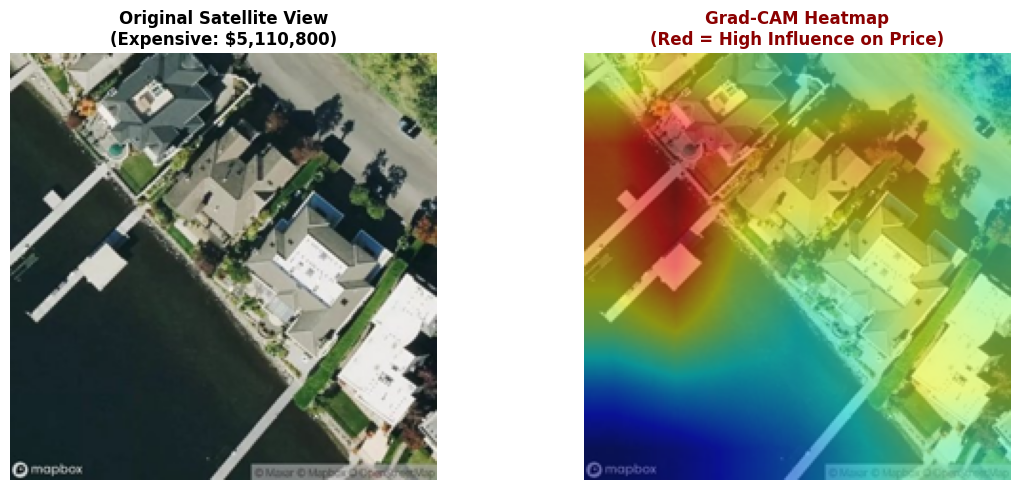

 SUCCESS! Comparison for Expensive saved as gradcam_comparison_expensive.jpg.


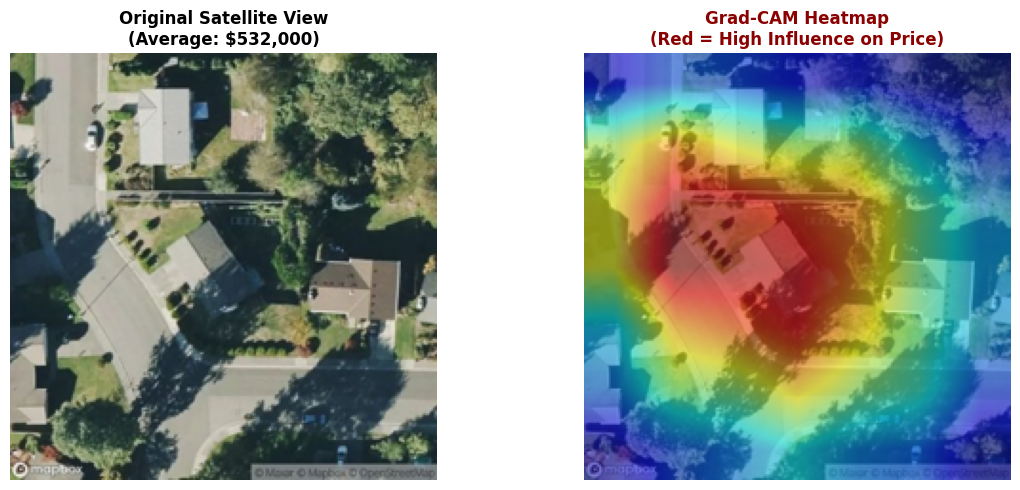

 SUCCESS! Comparison for Average saved as gradcam_comparison_average.jpg.


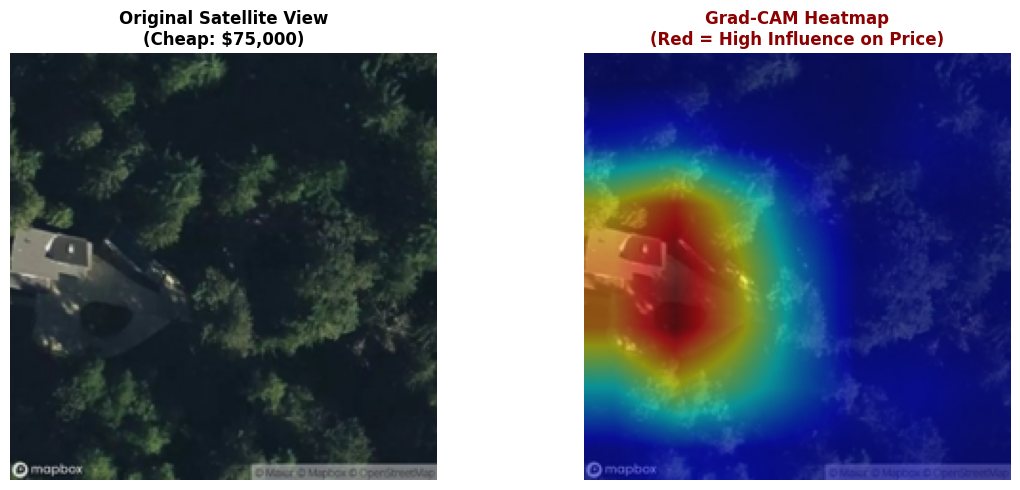

 SUCCESS! Comparison for Cheap saved as gradcam_comparison_cheap.jpg.

--- All comparisons generated for the project report! ---


In [18]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn
import matplotlib.pyplot as plt

class RegressionTarget:
    def __init__(self):
        pass
    def __call__(self, model_output):
        return model_output.sum()

class GradCAMWrapper(nn.Module):
    def __init__(self, model):
        super(GradCAMWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        x = self.model(x) 
        return x.mean().view(1, -1) 

wrapper_model = GradCAMWrapper(resnet).to(device).eval()
target_layers = [resnet[-2][-1]] 
cam = GradCAM(model=wrapper_model, target_layers=target_layers)

def generate_visual_explanation(img_path, tier_name, price):
    if not os.path.exists(img_path):
        print(f"Skipping: {img_path} not found.")
        return
        
    # Preprocess Image
    img_pil = Image.open(img_path).convert('RGB')
    img_pil_resized = img_pil.resize((224, 224))
    input_tensor = transform(img_pil_resized).unsqueeze(0).to(device)
    
    # Generate Heatmap
    targets = [RegressionTarget()]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # Create Overlay
    img_array = np.array(img_pil_resized) / 255.0
    visualization = show_cam_on_image(img_array, grayscale_cam, use_rgb=True)
    
    # PLOT SIDE-BY-SIDE
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: Original
    axes[0].imshow(img_pil_resized)
    axes[0].set_title(f"Original Satellite View\n({tier_name}: ${price:,.0f})", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Right: Grad-CAM Explainability
    axes[1].imshow(visualization)
    axes[1].set_title(f"Grad-CAM Heatmap\n(Red = High Influence on Price)", fontsize=12, fontweight='bold', color='darkred')
    axes[1].axis('off')
    
    plt.tight_layout()

    save_name = f"gradcam_comparison_{tier_name.lower()}.jpg"
    plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show() 
    
    print(f" SUCCESS! Comparison for {tier_name} saved as {save_name}.")

# 3. IDENTIFY DATA TIERS (Based on your final price arrays)
idx_expensive = np.argmax(y_val_orig)
idx_cheap = np.argmin(y_val_orig)
idx_average = (np.abs(y_val_orig - y_val_orig.mean())).argmin()

tier_data = {
    "Expensive": (val_ids.iloc[idx_expensive], y_val_orig[idx_expensive]),
    "Average": (val_ids.iloc[idx_average], y_val_orig[idx_average]),
    "Cheap": (val_ids.iloc[idx_cheap], y_val_orig[idx_cheap])
}

# 4. RUN BATCH GENERATION
print("--- Starting Tiered Visual Analysis ---")
for tier, (house_id, price) in tier_data.items():
    img_path = os.path.join(IMAGE_DIR, f"{house_id}.jpg")
    generate_visual_explanation(img_path, tier, price)

print("\n--- All comparisons generated for the project report! ---")

Red/Hot Zones: These are the areas the model "weighed" most heavily to determine the price (e.g., a pool, large yard, or waterfront).

Blue/Cold Zones: These areas were ignored by the model or seen as "standard" background.

In [25]:
X_test = np.load('X_test_scaled.npy')

In [27]:
test_df = pd.read_csv('../data/CDC_test.csv')
test_ids = test_df['id'].values
print(f"Total Test IDs captured: {len(test_ids)}")
print(f"Tabular features shape: {X_test.shape}")

Total Test IDs captured: 5404
Tabular features shape: (5404, 27)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

#  Setup ResNet-18 Extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity() # Remove final layer to get 512-D features
resnet.to(device)
resnet.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#  Extract Features for Downloaded Images
TEST_IMG_DIR = "house_images_dataset/test_zoom_18"
image_embeddings = {}

print("Extracting CNN Embeddings...")
with torch.no_grad():
    for img_name in tqdm(os.listdir(TEST_IMG_DIR)):
        if img_name.lower().endswith(('.jpg', '.jpeg')):
            img_id = int(img_name.split('.')[0])
            img_path = os.path.join(TEST_IMG_DIR, img_name)
            
            try:
                img = Image.open(img_path).convert('RGB')
                img_t = preprocess(img).unsqueeze(0).to(device)
                features = resnet(img_t).cpu().numpy().flatten()
                image_embeddings[img_id] = features
            except Exception as e:
                print(f"Error processing {img_id}: {e}")

#  Handle Missing IDs with Mean Imputation
# Calculate the mean of the embeddings we successfully extracted
all_extracted_vecs = np.array(list(image_embeddings.values()))
mean_embedding = all_extracted_vecs.mean(axis=0)

# Build the embedding matrix for all 5404 rows in test_df
final_embeddings = []
for house_id in test_ids:
    # This automatically handles duplicates and fills the missing 11
    final_embeddings.append(image_embeddings.get(house_id, mean_embedding))

X_test_cnn = np.array(final_embeddings)
print(f"Final CNN Matrix Shape: {X_test_cnn.shape}") 

Extracting CNN Embeddings...


100%|██████████| 5385/5385 [02:47<00:00, 32.16it/s]


Final CNN Matrix Shape: (5404, 512)


In [31]:
X_test_cnn_scaled = scaler_img.transform(X_test_cnn)
X_test_pca = pca.transform(X_test_cnn_scaled)

X_test_fusion = np.hstack((X_test, X_test_pca))

# Predict (Log scale)
log_preds = fusion_model2.predict(X_test_fusion)

# Inverse Log to get actual USD
final_prices = np.expm1(log_preds)

d:\CDC OPEN PROJECT\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [33]:
submission = pd.DataFrame({
    'id': test_ids,
    'predicted_price': final_prices
})
# Save to CSV
submission.to_csv('final_submission.csv', index=False)

print(submission.head())

           id  predicted_price
0  2591820310    171200.199088
1  7974200820    348853.352111
2  7701450110    330612.388771
3  9522300010    394629.812604
4  9510861140    316063.827482
